In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


 # HW4~6
 ## 目標
 執行 tf-idf, cluster, PCA 看看是否能讓機器看到一篇產業新聞的時候自動幫它分類
 ## 步驟
 1. 導入[爬蟲結果](https://github.com/ChiaYi-LIN/1072-CSX4001-B04704016/blob/master/HW4~6/crawler/tech_orange.ipynb)
 2. 導入[Jieba斷句結果](https://github.com/ChiaYi-LIN/1072-CSX4001-B04704016/blob/master/HW4~6/dictionary/news_to_seg.ipynb)
 3. tf-idf 計算文字與文章的關聯並紀錄權重
 4. cluster 將結果分為五群，看看分群結果能不能大致將產業分別開來
 5. PCA 將 tf-idf 的結果降維並根據 cluster 結果繪製散佈圖

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn import feature_extraction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.feature_extraction.text import TfidfTransformer
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
def tf_idf_weight(filelist=["ecommerce", "blockchain", "finance", "marketing", "travel"]):
    corpus = []
    for one_file in filelist:
        f = open("./dictionary/data/" + one_file + "_seg.txt", "r+", encoding="utf-8")
        content = f.read()
        f.close()
        content = content.split("\n")
        # Drop blank
        del content[-1]
        corpus.extend(content)

    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus)  
    transformer = TfidfTransformer()  
    tfidf = transformer.fit_transform(X)
    print(len(corpus))

    word = vectorizer.get_feature_names()
    weight = tfidf.toarray()
    print(len(word))
    print(len(weight))

    f = open("./tfidf_cluster_pca/tfidf/industry_words.txt", "w+", encoding="utf-8")
    for i in range(len(word)):
        f.write(word[i]+" ")
    f.write("\n")
    f.close()

    f = open("./tfidf_cluster_pca/tfidf/industry_words_tfidf_weight.txt", "w+", encoding="utf-8")
    for i in range(len(weight)):
        for j in range(len(word)):
            f.write(str(weight[i][j])+" ")
        f.write("\n")
    f.close()

    return(weight)

def load_data(filelist=["ecommerce", "blockchain", "finance", "marketing", "travel"], labellist=["電商", "區塊練", "金融", "行銷", "旅遊"]):
    mega_data = pd.DataFrame()
    for i in range(len(filelist)):
        with open("./crawler/data/tech_orange_" + filelist[i] + ".pkl", "rb") as handle:
            data = pickle.load(handle)
        data = data[::-1]
        data = pd.DataFrame(data)
        data["label"] = labellist[i]
        mega_data = pd.concat([mega_data, data])
    return(mega_data)


In [3]:
weight = tf_idf_weight()
data = load_data()


399
32831
399


In [4]:
number_of_clusters = 20
clf = KMeans(n_clusters=number_of_clusters)
clf.fit(weight)
pre = clf.predict(weight)
print(len(pre))

pca = PCA(n_components=2)
trans_data = pca.fit_transform(weight)
print(len(trans_data))

data["category"] = pd.DataFrame(pre)
data["pca1"] = pd.DataFrame(trans_data[:,0])
data["pca2"] = pd.DataFrame(trans_data[:,1])
data.to_pickle("./tfidf_cluster_pca/data_cluster_and_pca.pkl")
print(data.head(10))


399
399
                                             content        date  \
0  【我們為什麼挑選這篇文章】倍適得 17 家門市全收，代表了電商衝擊下，傳統零售該如何發揮優勢...  2017-12-08   
1  【我們為什麼挑選這篇文章】相信幾乎所有台灣人都有在博客來上網購的經驗！但是我們討論 PCho...  2017-12-08   
2  【我們為何挑選這則新聞】電商辦節慶促銷，民眾花錢不手軟，但是在消費結束以後，留下了什麼？答案...  2017-12-13   
3  【我們為什麼挑選這篇文章】蝦皮像是福壽螺外來種一樣入侵台灣，激盪起台灣電商環境的重大漣漪。不...  2017-12-14   
4  【我們為什麼挑選這篇文章】一切都是價格。當電商大戰大打免運費、快速到貨時，其實消費者最關心的...  2017-12-14   
5  【我們為什麼挑選這篇文章】 電商架站平台的挑選一直都是創業者的困擾，這麼多家廠商、這麼多樣的...  2017-12-15   
6  【我們為什麼挑選這篇文章】這兩天的大消息：騰訊和京東聯手入股唯品會，即將與阿里巴巴爭奪電商市...  2017-12-19   
7  就讀師大圖傳系的家昇，平時就很注重自己的健康、關注養生相關的資訊，本身也是一名拳擊手。「印象...  2017-12-19   
8  Facebook 廣告成本越發昂貴，為了解決這個問題，這次 awoo 阿物主辦的 2017 ...  2017-12-19   
9  【我們為什麼挑選這篇新聞】生鮮超市確實是零售中的一塊大餅，許多人前仆後繼地希望自己是存活下來...  2018-01-04   

                                                link   share  \
0  https://buzzorange.com/techorange/2017/12/08/b...   51 分享   
1  https://buzzorange.com/techorange/2017/12/08/b...  569 分享   
2  https://buzzorange.com/techorange/2017/12/13/i..

In [5]:
f = open("./tfidf_cluster_pca/cluster/cluster.txt", "w+", encoding="utf-8")
for i in range(number_of_clusters):
    one_category = data.loc[data["category"] == i]
    f.write("[Category: " + str(i) + "]\n")
    for each_row, each_title in one_category.iterrows():
        f.write(each_title["label"] + " " + each_title["title"] + "\n")
    f.write("\n")
f.close()


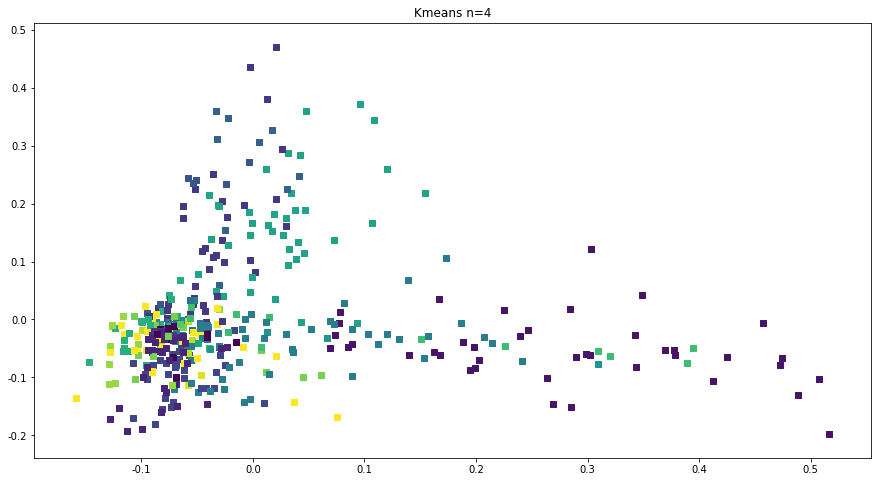

In [6]:
plt.figure(figsize=(15, 8))
plt.rcParams["axes.unicode_minus"]=False 
plt.title(u"Kmeans n=4")
plt.scatter(trans_data[:,0],trans_data[:,1],c=pre,marker="s")


 # 結論
 * 根據上圖和[聚類結果](https://github.com/ChiaYi-LIN/1072-CSX4001-B04704016/blob/master/HW4~6/tfidf_cluster_pca/cluster/cluster.txt)，發現這樣的文檔分類方法並不如預期。
 * 未來的改進方向:
   1. NER 抽取人名、地名、機構與專有名詞等等
   2. 使用 Jieba 斷句時載入自定義辭典，拆解出各個產業的專業用語
   3. 訓練詞向量模型